In [156]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
import transformers
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler,TensorDataset
# from datasets import Dataset
from torch.utils.data import Dataset 
import torch
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm.auto import tqdm
import evaluate
from torch.nn import CrossEntropyLoss
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
import os
import glob
import torch
import matplotlib.pyplot as plt
import numpy as np

In [157]:
# df = pd.read_csv("data/balancednewcategory.csv")
# df = pd.read_csv("data/5knewscategory.csv")
# df = pd.read_csv("data/100pernewscategory.csv")
df = pd.read_csv("data/400perMNDS.csv")
df.head()

,data_id,id,date,source,title,text,author,url,published,published_utc,collection_utc,category_level_1,category_level_2,PESTEL_label
0,202399,fortune--2019-02-26--Amazon Adds Former PepsiC...,2019-02-26,fortune,Amazon Adds Former PepsiCo Chief Indra Nooyi t...,Amazon has added former PepsiCo CEO Indra Nooy...,Erik Sherman,http://fortune.com/2019/02/26/amazon-board-ind...,2019-02-26 14:40:17+00:00,1551210017,1567547264,"economy, business and finance",business information,Economic
1,668391,theduran--2019-09-23--Pakistans Economic Crisis,2019-09-23,theduran,Pakistan’s Economic Crisis,Pakistan is going through financial woes. The ...,Serban V.C. Enache,https://theduran.com/pakistans-economic-crisis/,2019-09-23 07:49:51+00:00,1569239391,1570222447,"economy, business and finance",economic sector,Economic
2,1064343,unian--2019-09-06--Reuters Oil rises set for w...,2019-09-06,unian,"Reuters: Oil rises, set for weekly gain amid h...","Brent crude was up 17 cents, or 0.3%, at $61.1...",NaN,https://www.unian.info/economics/10675431-reut...,2019-09-06 06:00:00+00:00,1567764000,1569331139,"economy, business and finance",market and exchange,Economic
3,308315,mediamattersforamerica--2019-04-29--New NRA Pr...,2019-04-29,mediamattersforamerica,New NRA President Carolyn Meadows chairs the b...,"Carolyn Meadows, who is succeeding Oliver Nort...",Media Matters for America,https://www.mediamatters.org/blog/2019/04/29/n...,2019-04-29 21:18:38+00:00,1556587118,1567541775,"economy, business and finance",business information,Economic
4,494786,sottnet--2019-01-13--Saudi energy minister cla...,2019-01-13,sottnet,Saudi energy minister claims oil market on 'ri...,Saudi Arabia's top energy official expects the...,NaN,https://www.sott.net/article/404819-Saudi-ener...,2019-01-13 16:03:45+00:00,1547413425,1567552737,"economy, business and finance",market and exchange,Economic


In [158]:
# df["content"] = df["headline"] + " " + df["short_description"]
df["content"] = df["title"] + " " + df["text"]
df = df[['PESTEL_label', 'content']]
df.head()

KeyError: 'content'

In [ ]:
# convert content to string and handle NaN
df['content'] = df['content'].apply(lambda x: '' if pd.isna(x) else str(x))

In [ ]:
def clean_text(text):
    text = text.replace('\n', ' ').strip()
    return text

df['content'] = df['content'].apply(clean_text)

In [ ]:
# test set 20%
train_val_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df['PESTEL_label'], random_state=42
)

# train set 70%, val set 10%
train_df, val_df = train_test_split(
    train_val_df, test_size=0.125, stratify=train_val_df['PESTEL_label'], random_state=42
)

In [ ]:
class NewsDataset(Dataset):
    def __init__(self, data, tokenizer, max_len, pestel_to_idx):
        self.df = data
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.pestel_to_idx = pestel_to_idx

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index] 
        content = row['content']
        label = row['PESTEL_label']

        inputs = self.tokenizer.encode_plus(
            content,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )

        return {
            'ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'targets': torch.tensor(self.pestel_to_idx[label], dtype=torch.long)
        }
        
pestel_to_idx = {
    "Political": 0,
    "Economic": 1,
    "Social": 2,
    "Technological": 3,
    "Environmental": 4,
    "Legal": 5
}

In [ ]:
class_names = ["Political", "Economic", "Social", "Technological", "Environmental", "Legal"]

In [ ]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
distilbert_model = transformers.DistilBertModel.from_pretrained('distilbert-base-uncased')

In [ ]:
class PestelClassifier(torch.nn.Module):
    def __init__(self, distilbert, num_classes):
        super(PestelClassifier, self).__init__()
        self.distilbert = distilbert
        self.dropout = torch.nn.Dropout(0.3)
        self.output = torch.nn.Linear(768, num_classes)
        
        # self.classifier = torch.nn.Sequential(
        #     torch.nn.Linear(768, 256),
        #     torch.nn.ReLU(),
        #     torch.nn.Dropout(0.5),
        #     torch.nn.Linear(256, num_classes)
        # )

    def forward(self, ids, mask):
        output = self.distilbert(ids, attention_mask=mask)
        output = self.dropout(output[0][:, 0, :])  # CLS token
        output = self.output(output)
        return output
    
        # output = self.distilbert(ids, attention_mask=mask).last_hidden_state[:, 0, :]
        # output = self.classifier(output)
        # return output

In [ ]:
def evaluate_bert_model(model, data_loader, loss_function, device, set_name="Test"):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    loop = tqdm(data_loader, desc=f"{set_name} Evaluation")

    with torch.no_grad():
        for batch in loop:
            ids = batch['ids'].to(device)
            mask = batch['mask'].to(device)
            targets = batch['targets'].to(device)

            outputs = model(ids, mask)
            loss = loss_function(outputs, targets)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().tolist())
            all_targets.extend(targets.cpu().tolist())

            loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_targets, all_preds, average='macro', zero_division=0)

    print(f"{set_name} Loss: {avg_loss:.4f} | Acc: {accuracy*100:.2f}% | P: {precision:.4f} | R: {recall:.4f} | F1: {f1:.4f}")

    return avg_loss, accuracy, precision, recall, f1, all_preds, all_targets

In [ ]:
num_classes = 6  # For PESTEL
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PestelClassifier(distilbert_model, num_classes)
model.to(device)

PestelClassifier(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): 

In [ ]:
EPOCHS = 100
LEARNING_RATE = 5e-6
MAX_LEN = 512 # truncated as avg 4000 char per article is around 1000 tokens -> 512 is limit of DistilBERT
BATCH_SIZE = 16

train_set = NewsDataset(train_df, tokenizer, MAX_LEN, pestel_to_idx)
val_set = NewsDataset(val_df, tokenizer, MAX_LEN, pestel_to_idx)
test_set = NewsDataset(test_df, tokenizer, MAX_LEN, pestel_to_idx)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE,  weight_decay=0.01)
loss_function = torch.nn.CrossEntropyLoss()

In [ ]:
checkpoint = torch.load("./checkpoints_mnds_400per/best_model.pt", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

test_loss, test_accuracy, precision, recall, f1, preds, targets = evaluate_bert_model(
    model=model,
    data_loader=test_loader,
    loss_function=loss_function,
    device=device,
    set_name="Test"
)

print(f"Final Test Accuracy: {test_accuracy * 100:.2f}% | Test Loss: {test_loss:.4f}")

Test Evaluation: 100%|██████████| 30/30 [00:39<00:00,  1.30s/it, loss=0.0704]

Test Loss: 0.5206 | Acc: 85.83% | P: 0.8646 | R: 0.8583 | F1: 0.8583
Final Test Accuracy: 85.83% | Test Loss: 0.5206


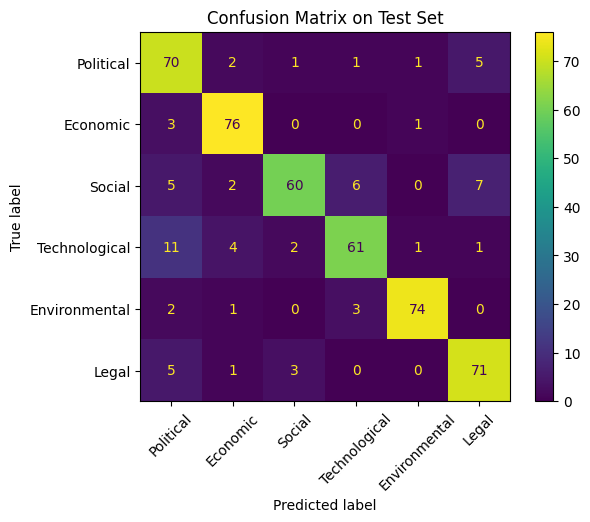

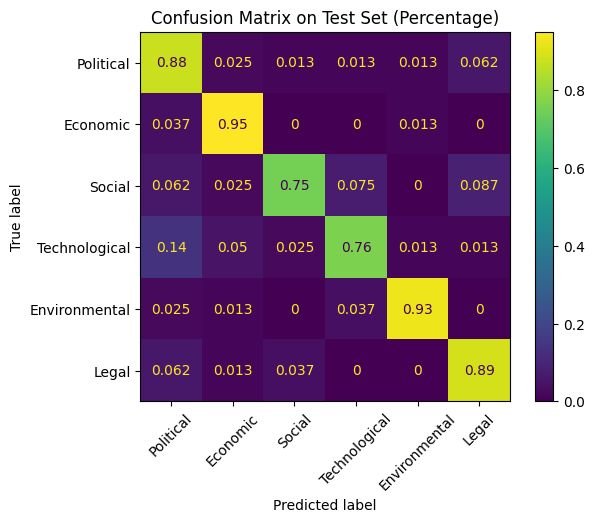

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(targets, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix on Test Set")
plt.show()

cm = confusion_matrix(targets, preds)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
cm_display = np.round(cm_percent, 5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_display, display_labels=class_names)
disp.plot(cmap='viridis', xticks_rotation=45)
plt.title("Confusion Matrix on Test Set (Percentage)")
plt.show()

In [ ]:
test_df = test_df.reset_index(drop=True)  # to align with test_set order

for i in range(len(preds)):
    if preds[i] != targets[i]:
        print(f"TEXT: {test_df.loc[i, 'content'][:100]}...")
        print(f"TRUE: {class_names[targets[i]]} | PREDICTED: {class_names[preds[i]]}")
        print('-' * 80)

TEXT: PENTAGON: Moscow outgunning USA in race for global influence... The U.S. is ill-equipped to counter ...
TRUE: Technological | PREDICTED: Political
--------------------------------------------------------------------------------
TEXT: Toxic Masculinity Attention boys: bullying, homophobia, sexual harassment and abuse are all your fau...
TRUE: Technological | PREDICTED: Social
--------------------------------------------------------------------------------
TEXT: Trump’s Tariffs Were Supposed to Ding China, But the U.S. Economy Is Getting Hit 2.5x Harder Faceboo...
TRUE: Economic | PREDICTED: Political
--------------------------------------------------------------------------------
TEXT: Economist Who Predicted 2008 Economic Crisis Warns of 2020 Recession Risk Economist Nouriel Roubini,...
TRUE: Technological | PREDICTED: Economic
--------------------------------------------------------------------------------
TEXT: Video: Man Fires Shots into Street From Assault Rifle Over Family C